<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [1]:
%pip install gensim
%pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras

import multiprocessing
from gensim.models import Word2Vec
from nltk.corpus import stopwords

### Datos
Para este ejercicio se uso un conjunto de datos tabulares públicos del gobierno de colombia que recopila información de uso y composición de diversos productos usados en el ámbito medico.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('insumos_dataset.csv', os.F_OK) is False:
  if platform.system() == 'Windows':
      !curl https://www.datos.gov.co/api/views/gnaj-fjem/rows.csv -o insumos_dataset.csv
  else:
      !wget insumos_dataset.csv https://www.datos.gov.co/api/views/gnaj-fjem/rows.csv
  # !unzip -q insumos_dataset.zip
  !mv rows.csv insumos_dataset.csv
else:
    print("El dataset ya se encuentra descargado")

--2025-07-17 20:16:19--  http://insumos_dataset.csv/
Resolving insumos_dataset.csv (insumos_dataset.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘insumos_dataset.csv’
--2025-07-17 20:16:19--  https://www.datos.gov.co/api/views/gnaj-fjem/rows.csv
Resolving www.datos.gov.co (www.datos.gov.co)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to www.datos.gov.co (www.datos.gov.co)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [   <=>              ] 655.09K   863KB/s    in 0.8s    

2025-07-17 20:16:22 (863 KB/s) - ‘rows.csv’ saved [670810]

FINISHED --2025-07-17 20:16:22--
Total wall clock time: 2.5s
Downloaded: 1 files, 655K in 0.8s (863 KB/s)


In [3]:
df = pd.read_csv('insumos_dataset.csv')
df.head()

,AÑO,# ACTA,# RADICADO,REQUIERE SI/NO,NUMERAL DEL ACTA,PRODUCTO,MARCA,USO,CONCEPTO,CLASIFICACIÓN,SOLICITANTE,VINCULO PARA CONSULTA DE ACTA
0,2007,3,7024456,NO,2.3,PRODUCTOS TERAPÉUTICOS CON HIERBAS NATURALES,NaN,NaN,Una vez evaluada la información allegada por e...,NaN,SUBDIRECCIÓN DE REGISTROS - INVIMA,https://www.invima.gov.co/documents/20143/1425...
1,2007,5,7042264,SI,2.3,TAPABOCAS,NaN,Uso en el ámbito asistencial,"Una vez evaluada la información, la Sala Espec...",NaN,MINISTERIO DE LA PROTECCIÓN SOCIAL,https://www.invima.gov.co/documents/20143/1425...
2,2007,5,7043552,SI,2.4,DIOXIDO DE CARBONO,NaN,CARBOXITERAPIA,"A concepto de la Sala, este equipo pertenece a...",III,SUBDIRECCIÓN DE REGISTRO SANITARIO DEL INVIMA,https://www.invima.gov.co/documents/20143/1425...
3,2008,1,7045482,SI,2.1,"Lentes de contacto, lentes de contacto con fin...",NaN,Corrección de defectos visuales,La Sala Especializada de Dispositivos Médicos ...,NaN,SUBDIRECCIÓN DE REGISTROS -INVIMA,https://www.invima.gov.co/documents/20143/1425...
4,2008,1,7048345,SI,2.2,TAPABOCAS,NaN,Uso hospitalario,La Sala Especializada de Dispositivos Médicos ...,NaN,CARLOS DARIO ARENAS,https://www.invima.gov.co/documents/20143/1425...


In [4]:
df["CONCEPTO"]

,CONCEPTO
0,Una vez evaluada la información allegada por e...
1,"Una vez evaluada la información, la Sala Espec..."
2,"A concepto de la Sala, este equipo pertenece a..."
3,La Sala Especializada de Dispositivos Médicos ...
4,La Sala Especializada de Dispositivos Médicos ...
...,...
836,Una vez revisada y evaluada la nueva justifica...
837,Una vez revisada y evaluada la nueva justifica...
838,Una vez analizada y evaluada la información al...
839,ESTE SPRAY NASAL PROTECTOR ESTÁ DISEÑADO PARA ...


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 841


### 1 - Preprocesamiento

Dado que este conjunto de datos corresponde a una tabla con varios parametros de los datos se decidio solo tomar uno de los campos para el analisis de texto.

El campo escogido para el analisis de texto sera "CONCEPTO" ya que es el que posee valores con mayor longitud de palabras


In [6]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence


sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for row in df["CONCEPTO"]:
    sentence_tokens.append(text_to_word_sequence(str(row)))

In [7]:
# Demos un vistazo
sentence_tokens[:2]

[['una',
  'vez',
  'evaluada',
  'la',
  'información',
  'allegada',
  'por',
  'el',
  'interesado',
  'la',
  'sala',
  'especializada',
  'de',
  'dispositivos',
  'médicos',
  'y',
  'productos',
  'varios',
  'de',
  'la',
  'comisión',
  'revisora',
  'del',
  'invima',
  'conceptúa',
  'que',
  'por',
  'las',
  'características',
  'de',
  'los',
  'productos',
  'suministradas',
  'en',
  'la',
  'información',
  'anexada',
  'no',
  'es',
  'claro',
  'que',
  'se',
  'traten',
  'de',
  'dispositivos',
  'médicos',
  'dado',
  'que',
  'el',
  'diseño',
  'de',
  'los',
  'productos',
  'no',
  'se',
  'relaciona',
  'con',
  'las',
  'indicaciones',
  'o',
  'beneficios',
  'exagerados',
  'de',
  'los',
  'mismos',
  'tratamiento',
  'del',
  'mal',
  'de',
  'parkinson',
  'otitis',
  'entre',
  'otros',
  'por',
  'lo',
  'tanto',
  'es',
  'necesario',
  'evaluar',
  'si',
  'esta',
  'acción',
  'es',
  'debida',
  'a',
  'la',
  'mezcla',
  'de',
  'hierbas',
  'y',

### 2 - Crear los vectores (word2vec)

In [8]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [49]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=2,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=6,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

**NOTA:** Dado que se esta usando una representacion de tipo Skipgram se espera que los terminos que mas se relacionen entre si sean aquellos con los que comparten pares de palabras similares.

In [65]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=2,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=6,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [66]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [11]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 841


In [12]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 1470


### 3 - Entrenar embeddings

In [67]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 166769.421875
Loss after epoch 1: 116346.796875
Loss after epoch 2: 111050.4375
Loss after epoch 3: 105236.71875
Loss after epoch 4: 100292.0625
Loss after epoch 5: 97922.5625
Loss after epoch 6: 97145.875
Loss after epoch 7: 95575.5625
Loss after epoch 8: 93528.8125
Loss after epoch 9: 89594.625
Loss after epoch 10: 85470.0
Loss after epoch 11: 83494.75
Loss after epoch 12: 82039.375
Loss after epoch 13: 80846.5
Loss after epoch 14: 79947.125
Loss after epoch 15: 79257.375
Loss after epoch 16: 78401.0
Loss after epoch 17: 77894.25
Loss after epoch 18: 77509.375
Loss after epoch 19: 77427.125


(671132, 1230500)

### 4 - Ensayar

In [63]:
w2v_model.wv.most_similar(positive=["bolsas"], topn=10)


[('decreto', 0.19958770275115967),
 ('existen', 0.18756063282489777),
 ('mist', 0.1815655529499054),
 ('mencionados', 0.17640122771263123),
 ('incluidas', 0.17574633657932281),
 ('aseo', 0.16610169410705566),
 ('específica', 0.1648564338684082),
 ('reactividad', 0.16014736890792847),
 ('andina', 0.15644484758377075),
 ('cie', 0.15510213375091553)]

In [52]:
w2v_model.wv.most_similar(positive=["bolsas"], topn=10)

[('ostomías', 0.8601856827735901),
 ('utilizadas', 0.7724570035934448),
 ('catalogados', 0.7611569166183472),
 ('leche', 0.7497243881225586),
 ('balanzas', 0.745357096195221),
 ('fisiológico”', 0.7414872050285339),
 ('recolección', 0.7330653071403503),
 ('imágenes', 0.7330201864242554),
 ('materna”', 0.7326859831809998),
 ('manejo', 0.73073810338974)]

In [20]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["manufactura"], topn=10)

[('prácticas', 0.9221839308738708),
 ('buenas', 0.8666620850563049),
 ('bolsas', 0.8643099665641785),
 ('transporte', 0.849044919013977),
 ('ostomías', 0.848882257938385),
 ('organización', 0.8257121443748474),
 ('nivel', 0.8228573203086853),
 ('actividades', 0.8220196962356567),
 ('imágenes', 0.816458523273468),
 ('quemaduras', 0.8081095814704895)]

Se observa que algunas de los terminos guardan una relación de emparejamiento. Los 3 primeros terminos listados son frecuentemente encontrados cerca del termino "manufactura". Un ejemplo es en oraciones como:

* El cual debe contar con Buenas Prácticas de Manufactura


**Nota:** El ejemplo fue extraido directamente del archivo

In [68]:
w2v_model.wv.most_similar(positive=["imágenes"], topn=20)


[('plaquetas', 0.9491131901741028),
 ('carillas', 0.9444553852081299),
 ('frasco', 0.9438620805740356),
 ('uñas', 0.9421066045761108),
 ('capilar', 0.9415808320045471),
 ('fijación', 0.9412669539451599),
 ('medir', 0.9392156600952148),
 ('piloso', 0.9382162094116211),
 ('labios', 0.9376094937324524),
 ('pantallas', 0.9329408407211304),
 ('coronas', 0.9328274130821228),
 ('puentes', 0.9322515726089478),
 ('diagnósticas', 0.9320552945137024),
 ('elaboración', 0.93086177110672),
 ('realizan', 0.9277847409248352),
 ('metabolismo', 0.9259480834007263),
 ('calor', 0.9250803589820862),
 ('suministran', 0.9249154329299927),
 ('conocidos', 0.924912691116333),
 ('adaptación', 0.9246619939804077)]

Este termino lo tomé del ejemplo anterior esperando que aparciera "manufactura" como un termino relacionado, en su lugar aparecio "elaboración" que es un termino que guarda relacion semantica con "manufactura". El termino "manufactura" aparecio como decimo tercer valor mas relacionado

En el corpus el termino "imágenes" se presentó en las siguientes oraciones:
* Sistema de Digitalización de Imágenes Diagnósticas
para reproducir o visualizar imágenes médicas, requerirán de registro sanitario,
* para adquirir  rápidamente  imágenes  de  láminas  completas  con  un  microscopio
* almacenamiento de las imágenes diagnosticas; el sistema de almacenamiento

Notar que de los terminos relacionados enlistados ninguno aparace en estas oraciones

In [26]:
# Aquí se buscó los parrafos que contenieran la subcadena "imágenes"

termino_imagenes_corpus = df[df['CONCEPTO'].str.contains('imágenes')].loc[:,['CONCEPTO']]

for t in termino_imagenes_corpus['CONCEPTO']:
  print(f'{t}\n')

La Sala Especializada de Dispositivos Médicos y Productos Varios de la Comisión Revisora del INVIMA, considera que este es un sistema de apoyo para el almacenamiento de las imágenes diagnosticas; el sistema de almacenamiento no compromete el diagnostico final, razón por la cual ratificamos que este producto NO requiere Registro Sanitario.

Esta Sala ratifica que los siguientes productos son considerados Dispositivos Médicos: Sistema de digitalización de imágenes diagnósticas

La Sala de Dispositivos Médicos y Otras Tecnologías, conceptúa que de conformidad con la definición de dispositivo médico para uso en humanos, el producto en mención es considerado dispositivo médico, por cuanto, ayuda al Diagnóstico de una enfermedad o de una lesión. En este sentido, su clasificación de riesgo es IIA, teniendo presente la Regla de clasificación 10, así: “…Regla 10. Todos los dispositivos médicos activos con fines de diagnóstico se incluirán en la clase IIa…” Por lo tanto para su importación, come

### Evaluación de la aparacición de los terminos relacionados en el corpus
Se solicito a chatgpt version 4o que aplicara negrita a los terminos mas relacionados en el resultado que se imprimió en la celda anterior, se obtuvo el siguiente resultado:


Aquí tienes el texto formateado con las palabras clave en negrita:

La Sala Especializada de Dispositivos Médicos y Productos Varios de la Comisión Revisora del INVIMA, considera que este es un sistema de apoyo para el almacenamiento de las imágenes diagnósticas; el sistema de almacenamiento no compromete el diagnóstico final, razón por la cual ratificamos que este producto NO requiere Registro Sanitario.

Esta Sala ratifica que los siguientes productos son considerados Dispositivos Médicos: Sistema de digitalización de imágenes diagnósticas

La Sala de Dispositivos Médicos y Otras Tecnologías, conceptúa que de conformidad con la definición de dispositivo médico para uso en humanos, el producto en mención es considerado dispositivo médico, por cuanto, ayuda al Diagnóstico de una enfermedad o de una lesión. En este sentido, su clasificación de riesgo es IIA, teniendo presente la Regla de clasificación 10, así: “…Regla 10. Todos los dispositivos médicos activos con fines de diagnóstico se incluirán en la clase IIa…” Por lo tanto para su importación, comercialización y uso, las pantallas o monitores grado médico indicado para reproducir o visualizar imágenes médicas, requerirán de registro sanitario, para lo cual los fabricantes e importadores, dispondrán de un periodo de transitoriedad de 6 meses a partir de la fecha de publicación de la presente Acta, para la respectiva obtención del registro sanitario.

Una vez analizada y evaluada la información allegada, la Sala Especializada de Dispositivos Médicos y Reactivos de Diagnóstico In Vitro, conceptúa que ratifica el concepto proferido en el numeral 3.8 del Acta 12 de 2021, teniendo en cuenta la indicación de uso, para adquirir rápidamente imágenes de **láminas** completas con un microscopio trinocular y compartirlas, el producto Pathozoom Scan / Sistema de escaneo / Pathozoom es considerado dispositivo médico con clasificación de riesgo I, de conformidad con la regla 12 del artículo 7 del Decreto 4725 de 2005. Por lo tanto, para ser utilizado y comercializado en Colombia debe solicitar el respectivo registro sanitario.

Las demás palabras que solicitaste como **recolección**, **bolsas**, **canalización**, **centrífugas**, **lavado**, **elaboración**, **transporte**, **pruebas**, **obtener**, **manejo**, **capacidad**, **manufactura**, **clínico**, **frío**, **líquido**, **procesadores**, **gestión**, **cirugía**, **banco**, no se encuentran en el texto original, por lo tanto no fueron resaltadas.


### Resultados
* Los terminos mas relacionados según la similaridad coseno no mantienen salvo relacion semántica significativa.
* Para la mayoria de los casos los terminos más relacionados no aparecen juntos con nuestro termino objetivo. Esto se explica porque la relacion que estos terminos, usando el vectorizador skipgram, esta dado por los pares de terminos que se forman.
* Otra razon por la que aparecen terminos con baja relacion semántica podria deberse al alto error de entrenamiento

Además se probó los resultados obtenidos con distintos hiperparámetros obteniendo los siguientes resultados:



### Mismos hiperparámetros pero el entrenamiento se hizo con 50 épocas
```
w2v_model = Word2Vec(min_count=5,
                    window=2,     
                    vector_size=300,
                    negative=20,    
                    workers=1,      
                    sg=1)         
                     
[('láminas', 0.7249535322189331),
 ('formadora', 0.6770811676979065),
 ('centrífugas', 0.6725326180458069),
 ('odontológico', 0.6681994199752808),
 ('canalización', 0.6679340600967407),
 ('recolección', 0.6608675718307495),
 ('tampoco', 0.6521221399307251),
 ('película', 0.6419997811317444),
 ('ostomías', 0.63898104429245),
 ('body', 0.6294649243354797),
 ('fluidos', 0.6284018158912659),
 ('lavado', 0.6259608864784241),
 ('manejo', 0.6205415725708008),
 ('procesadores', 0.612420916557312),
 ('hospitalario', 0.6117451190948486),
 ('microscopio', 0.6101122498512268),
 ('“solución', 0.601662814617157),
 ('órganos', 0.6008421182632446),
 ('requerirán', 0.5993873476982117),
 ('partes', 0.5933358669281006)]

 ```

 **Notar** que 'lámina' ahora aparece ahora como termino con mayor similaridad. Además los términos "lámina" y "película" guaradan mayor relacion semántica


 ### El entrenamiento uso 20 épocas y se aumento la ventana para la n-gramas
 ```
w2v_model = Word2Vec(min_count=5,    
                     window=6,       
                     vector_size=300,
                     negative=20,    
                     workers=1,      
                     sg=1)

[('láminas', 0.821029007434845),
 ('microscopio', 0.7808202505111694),
 ('tampoco', 0.7589981555938721),
 ('líquido', 0.7556858062744141),
 ('recolección', 0.7531719207763672),
 ('congeladores', 0.7494942545890808),
 ('procesadores', 0.7358418107032776),
 ('básculas', 0.7205345630645752),
 ('bolsas', 0.7145042419433594),
 ('origen', 0.7142723202705383),
 ('centrífugas', 0.7106561064720154),
 ('transporte', 0.7073239088058472),
 ('refrigeradores', 0.6882241368293762),
 ('balanzas', 0.6821379661560059),
 ('ni', 0.6773539781570435),
 ('indicado', 0.6735020279884338),
 ('dientes', 0.6661387085914612),
 ('co2', 0.6634300351142883),
 ('estériles', 0.6551840901374817),
 ('soluciones', 0.6539809703826904)]          

 ```

 Ahora se ven algunos terminos como: 'lámina','microscopio' e 'indicado' las cuales también aparecen juntas con nuestro termino objetivo en el corpus.
 Notar que tambien aparecen algunos stopwords

### Disminución del valor minimo de frecuencia

 ```
 w2v_model = Word2Vec(min_count=2,    
                     window=6,       
                     vector_size=300,
                     negative=20,    
                     workers=1,      
                     sg=1)           

[('digitalización', 0.8846588134765625),
 ('plaquetas', 0.8151108622550964),
 ('medir', 0.8043680191040039),
 ('pantallas', 0.8039793968200684),
 ('fresado', 0.7930883169174194),
 ('bloques', 0.7882126569747925),
 ('manipulación', 0.7873685359954834),
 ('yesos', 0.7836945652961731),
 ('láminas', 0.781622052192688),
 ('diagnósticas', 0.7786082029342651),
 ('lectura', 0.7760277390480042),
 ('inmovilización', 0.7698107361793518),
 ('declarada', 0.7677138447761536),
 ('coloración', 0.7669142484664917),
 ('frasco', 0.7660395503044128),
 ('tubo', 0.7616411447525024),
 ('liquidos', 0.7610458731651306),
 ('binocular', 0.7609883546829224),
 ('oscilante', 0.7593356370925903),
 ('hematocrito', 0.7591260075569153)]

 ```

 Se observa que los valores de similaridad coseno aumentaron. A su vez hay términos con mayor relacion semántica como: 'pantallas', 'láminas', 'lectura' y 'binocular'


 ### Mismo hiperparámetros pero con tipo de vectorización CBOW

 ```
 w2v_model = Word2Vec(min_count=2,
                     window=6,
                     vector_size=300,
                     negative=20,   
                     workers=1,     
                     sg=0)  

 [('plaquetas', 0.9491131901741028),
 ('carillas', 0.9444553852081299),
 ('frasco', 0.9438620805740356),
 ('uñas', 0.9421066045761108),
 ('capilar', 0.9415808320045471),
 ('fijación', 0.9412669539451599),
 ('medir', 0.9392156600952148),
 ('piloso', 0.9382162094116211),
 ('labios', 0.9376094937324524),
 ('pantallas', 0.9329408407211304),
 ('coronas', 0.9328274130821228),
 ('puentes', 0.9322515726089478),
 ('diagnósticas', 0.9320552945137024),
 ('elaboración', 0.93086177110672),
 ('realizan', 0.9277847409248352),
 ('metabolismo', 0.9259480834007263),
 ('calor', 0.9250803589820862),
 ('suministran', 0.9249154329299927),
 ('conocidos', 0.924912691116333),
 ('adaptación', 0.9246619939804077)]

 ```

 Se obtuvieron mayores valores de similaridad coseno sin embargo la mayoría no presentan una alta relacion de significado. Los terminos con cierta relacion semántica son: "plaquetas" y "pantallas"

In [53]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["imágenes"], topn=10)

[('medicamentos', -0.08017455041408539),
 ('más', -0.1048942431807518),
 ('cual', -0.10634894669055939),
 ('farmacológica', -0.12538868188858032),
 ('decisión', -0.15930920839309692),
 ('norma', -0.16936300694942474),
 ('”', -0.17163892090320587),
 ('5', -0.18107016384601593),
 ('según', -0.18370792269706726),
 ('fin', -0.18488401174545288)]

In [54]:
# el método `get_vector` permite obtener los vectores:
vector_sala = w2v_model.wv.get_vector("sala")
print(vector_sala)

[-4.89761412e-01  3.72975558e-01  8.82901475e-02 -2.71589488e-01
  5.43643124e-02 -4.98575509e-01  8.80033970e-02  7.22281635e-01
  3.45015347e-01 -7.00053647e-02  5.47095435e-03 -4.76431876e-01
  8.62234756e-02  1.63256302e-01 -3.75060081e-01 -3.18589598e-01
  3.16010594e-01  1.83688045e-01  2.39949524e-01 -4.01739925e-02
 -4.33488250e-01 -4.13156338e-02 -9.53004435e-02  1.56079128e-01
  1.74809638e-02 -2.64982522e-01 -2.83577949e-01 -3.05741310e-01
 -4.03728694e-01  5.98425865e-02  2.48028502e-01 -1.14729777e-01
 -2.26726145e-01 -3.48377898e-02  3.20394225e-02 -2.16448203e-01
 -1.72314644e-01  3.72719318e-01 -3.19345966e-02  1.30716681e-01
 -1.59831375e-01 -6.98656775e-04 -2.25085333e-01  1.10402592e-01
 -1.16905689e-01  1.92817468e-02  3.01418513e-01  2.32492462e-02
 -2.02103227e-01 -1.53186992e-01 -9.54538286e-02  1.66830823e-01
  1.49597332e-01  2.10201308e-01 -8.70123431e-02  5.91483474e-01
 -1.35685548e-01  4.46712505e-03  2.00370383e-02  9.39199924e-02
  3.03840898e-02 -6.05506

In [55]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_sala)

[('sala', 1.0000001192092896),
 ('encías', 0.6873774528503418),
 ('especializada', 0.6860439777374268),
 ('suplementos', 0.6636673212051392),
 ('estudiada', 0.65818190574646),
 ('fitoterapéuticos', 0.6567934155464172),
 ('usado', 0.651395857334137),
 ('especializadas', 0.6509262323379517),
 ('informacion', 0.6502572298049927),
 ('dietarios', 0.6499263048171997)]

### 5 - Visualizar agrupación de vectores

In [57]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [58]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

 ### Resultado
 Explorando el se pudo hallar que algunos términos que se encontraban juntos mantienen cierta relacion semántica. Esto a pesar de la reduccion de dimensionalidad que ocurre por representar los vectores en un espacio de apenas 2 dimensiones

 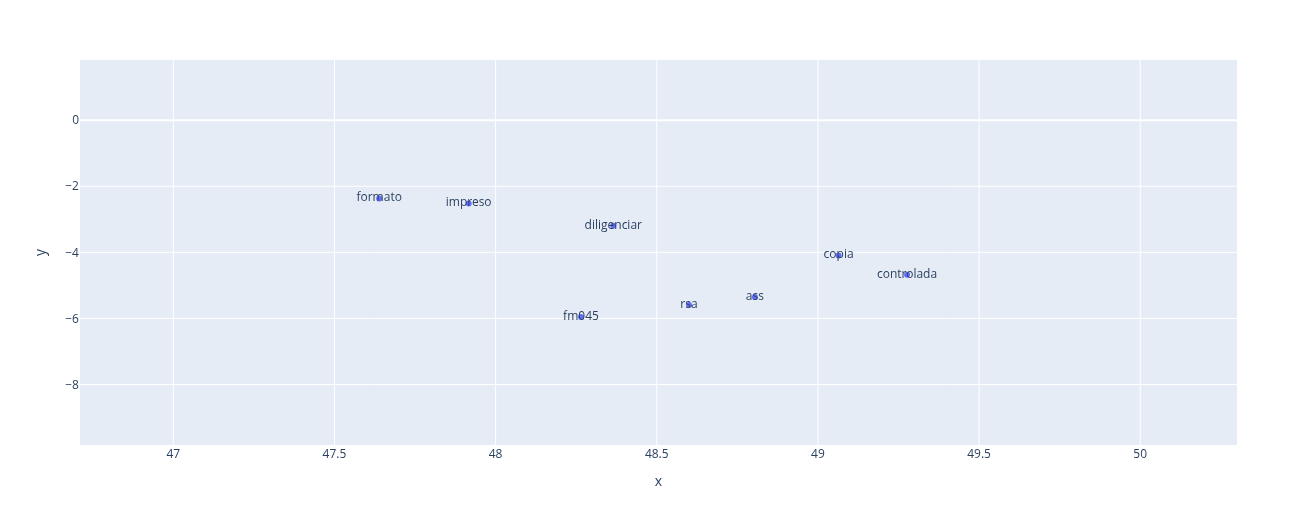

In [59]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [60]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

## Resultados
* Se obtuvieron embeddings con los términos del conjunto de datos públicos del gobierno de Colombia, especificamente la informacion de "concepto" de los productos usados como insumos en el ámbito médico.
*  Se probaron diferentes configuraciones de hiperpárametrosy se analizó las similiridad de los embeddings, obteniendo pocos términos que guardaban una relacion semántica relevante
* Se visulizó en un espacio de menor dimensionalidad 2D y 3D. En los que se pudo observar que algunos términos mantenián una relacion en dichos planos a pesar que la agresiva reduccion de campos


## Conclusiones
* La similaridad coseno varía mucho dependiendo de como se contruyen los vactores y no representa una métrica fiable para distinguir que términos tienen una alta relación semantica entre sí.
* Es muy complicado obtener términos con relación semántica. Dado que se requiere de un corpus balanceado y los hiperparámetros adecuados para vectorizar con suficiente complejidad a los términos